### Import Required Libraries

In [1]:
import string
import re
import numpy as np
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed, SimpleRNN, Flatten, GRU
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


### Read Data

Our data is a text file of English-German sentence pairs. First we will read the file using the function defined below.

In [2]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [3]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

__Download the data from [here.](http://www.manythings.org/anki/deu-eng.zip)__ and extract "deu.txt" in your working directory.

In [33]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

The actual data contains over 150,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [34]:
deu_eng = deu_eng[:50000,:]

### Text Pre-Processing

In [35]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['You need not go there.', 'Du musst nicht dorthin gehen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #70007 (CM) & #1813634 (Pfirsichbaeumchen)'],
       ['You need not go there.', 'Du brauchst nicht dorthin zu gehen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #70007 (CM) & #1813635 (Pfirsichbaeumchen)'],
       ['You need to apologize.', 'Du musst dich entschuldigen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3826573 (CK) & #3928528 (Tamy)']],
      dtype='<U537')

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [36]:
deu_eng = np.delete(deu_eng, 2, axis=1)

In [37]:
deu_eng

array([['Go.', 'Geh.'],
       ['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ...,
       ['You need not go there.', 'Du musst nicht dorthin gehen.'],
       ['You need not go there.', 'Du brauchst nicht dorthin zu gehen.'],
       ['You need to apologize.', 'Du musst dich entschuldigen.']],
      dtype='<U537')

We will get rid of the punctuation marks, and then convert the text to lower case.

In [38]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [39]:
deu_eng

array([['Go', 'Geh'],
       ['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ...,
       ['You need not go there', 'Du musst nicht dorthin gehen'],
       ['You need not go there', 'Du brauchst nicht dorthin zu gehen'],
       ['You need to apologize', 'Du musst dich entschuldigen']],
      dtype='<U537')

In [40]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [41]:
deu_eng

array([['go', 'geh'],
       ['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ...,
       ['you need not go there', 'du musst nicht dorthin gehen'],
       ['you need not go there', 'du brauchst nicht dorthin zu gehen'],
       ['you need to apologize', 'du musst dich entschuldigen']],
      dtype='<U537')

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [42]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [43]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})
print(length_df)
print(max(length_df.eng))
print(max(length_df.deu))

eng  deu
0        1    1
1        1    1
2        1    2
3        1    1
4        1    1
...    ...  ...
49995    4    5
49996    5    5
49997    5    5
49998    5    6
49999    4    4

[50000 rows x 2 columns]
7
15


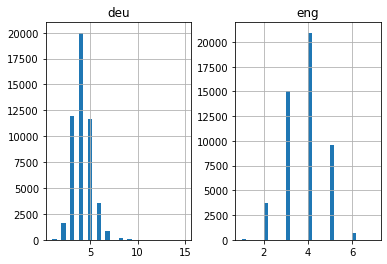

In [44]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the German sentences is 11 and that of the English phrases is 8.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [4]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [46]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6331


In [47]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10455


In [48]:
print(deu_tokenizer.word_counts)

tete', 3), ('eingeschaltet', 2), ('benutzte', 2), ('zahnstocher', 1), ('bang', 1), ('nervosität', 1), ('auspacken', 1), ('einrad', 1), ('holzfäller', 1), ('lebendigem', 1), ('leibe', 1), ('elektrisch', 1), ('geisel', 1), ('hauslehrer', 1), ('kabine', 1), ('führerhaus', 1), ('kajüte', 1), ('hütte', 1), ('beschützer', 1), ('selbstmordkandidat', 1), ('skrupellos', 1), ('populär', 2), ('geguckt', 1), ('safari', 1), ('klapperte', 1), ('sehenswürdigkeiten', 2), ('wackelte', 2), ('weiterhin', 2), ('nikolausmütze', 1), ('strohhut', 1), ('zusammengearbeitet', 1), ('zurückschlagen', 1), ('karriere', 3), ('mobiltelefon', 1), ('zitterten', 1), ('trockenen', 1), ('instinkten', 4), ('intuition', 1), ('sauce', 1), ('arbeitslosigkeit', 1), ('strenge', 1), ('besucher', 1), ('anstellen', 1), ('reflektiert', 1), ('spiegelt', 1), ('wider', 1), ('geschnitzt', 1), ('klären', 1), ('davonlaufen', 1), ('schützen', 1), ('paddelten', 1), ('flussabwärts', 2), ('gemeinsam', 3), ('falsches', 2), ('zuschulden', 1), 

Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [5]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

<bound method Tokenizer.texts_to_sequences of <keras_preprocessing.text.Tokenizer object at 0x000001D5AD17AA08>>


### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [50]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [24]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

[[ 203  102   48 ...    0    0    0]
 [   1   20  180 ...    0    0    0]
 [  97  784 2968 ...    0    0    0]
 ...
 [   1  202 7407 ...    0    0    0]
 [  17  274  659 ...    0    0    0]
 [   9   10   36 ...    0    0    0]]
[[  11    3   23 ...    0    0    0]
 [   2   13  188 ...    0    0    0]
 [  56 1295  525 ...    0    0    0]
 ...
 [   2  283 3034 ...    0    0    0]
 [   8  614    4 ...    0    0    0]
 [  10 1723    5 ...    0    0    0]]


In [27]:
print(trainX.shape)
print(trainY.shape)

(40000, 8)
(40000, 8)


In [25]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

[[ 21 566 500 ...   0   0   0]
 [  1 346  18 ...   0   0   0]
 [  7 195  15 ...   0   0   0]
 ...
 [  2   3  12 ...   0   0   0]
 [ 57  33   8 ...   0   0   0]
 [ 29  67  11 ...   0   0   0]]
[[  3  57   7 ...   0   0   0]
 [  2 157 162 ...   0   0   0]
 [ 12 356   1 ...   0   0   0]
 ...
 [  1   4   5 ...   0   0   0]
 [ 54 175   3 ...   0   0   0]
 [ 39  11  20 ...   0   0   0]]


In [28]:
print(testX.shape)
print(testY.shape)

(10000, 8)
(10000, 8)


Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [6]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

Details about the RepeatVector :  https://campus.datacamp.com/courses/machine-translation-in-python/implementing-an-encoder-decoder-model-with-keras?ex=6

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [29]:
print(deu_vocab_size)
print(eng_vocab_size)
print(deu_length)
print(eng_length)

10597
6361
8
8


In [30]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [31]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

C:\Users\ana_2\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 270s 8ms/step - loss: 3.4852 - val_loss: 2.9231

Epoch 00001: val_loss improved from inf to 2.92312, saving model to model.h1.24_jan_19
Epoch 2/30
32000/32000 [==============================] - 256s 8ms/step - loss: 2.8514 - val_loss: 2.8277

Epoch 00002: val_loss improved from 2.92312 to 2.82767, saving model to model.h1.24_jan_19
Epoch 3/30
32000/32000 [==============================] - 38819s 1s/step - loss: 2.6708 - val_loss: 2.6531

Epoch 00003: val_loss improved from 2.82767 to 2.65306, saving model to model.h1.24_jan_19
Epoch 4/30
32000/32000 [==============================] - 172s 5ms/step - loss: 2.4866 - val_loss: 2.5386

Epoch 00004: val_loss improved from 2.65306 to 2.53858, saving model to model.h1.24_jan_19
Epoch 5/30
32000/32000 [==============================] - 165s 5ms/step - loss: 2.3500 - val_loss: 2.4082

Epoch 00005: val_loss improved from 2.53858 to 2.40816,

Let's compare the training loss and the validation loss.

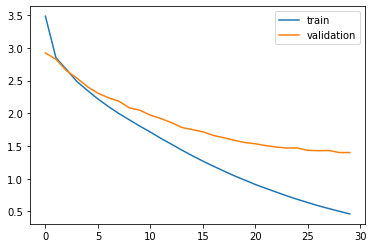

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [33]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

C:\Users\ana_2\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [6]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [35]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [31]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [37]:
pd.set_option('display.max_colwidth', 200)

In [38]:
pred_df.head(15)

,actual,predicted
0,you need to wake up,you should to awake
1,i feel old,i feel old
2,im sorry tom,sorry it
3,hide the money,is money
4,is someone calling me,help me
5,you should work hard,you should work hard
6,tom has a big problem,tom has a small nose
7,he lives with his mom,he lives her old
8,whats toms job,whats toms job
9,i dont want to drive,i dont want to


In [39]:
pred_df.tail(15)

,actual,predicted
9985,do you need a ride,can i sit you
9986,it is very small,its very small
9987,we can handle that,we can count it
9988,nobody believes you,no one believes you
9989,tom never changes,tom never laughs
9990,i just emailed you,i just found him tom
9991,tom is so stupid,tom is so stupid
9992,i found tom,i found tom
9993,i met mary yesterday,i saw her yesterday
9994,try and stop me,try to me


In [37]:
pred_df.tail(15)

,actual,predicted
9985,tom knew the risks,tom was all of
9986,what does she do,what does you do
9987,she still loved him,she still him sing
9988,i want to be careful,i want to be boston
9989,im here arent i,im here
9990,youre a hypocrite,youre a hypocrite
9991,i gave you a book,i gave you a book
9992,lets do it,do it
9993,i broke my leg skiing,i broke my
9994,i was victorious,i was been asleep


In [40]:
pred_df.sample(15)

,actual,predicted
3769,are you overweight,are you
6744,i didnt see a ghost,i didnt not a
1956,the price is going up,the wind is come
6860,tom isnt a painter,tom isnt a
1201,am i boring you,am i boring you
7790,its getting late,its is late
8263,its worthless junk,its not no
6170,heres some water,heres a just
1436,mary sings soprano,mary is at a
5354,i have a truck,i have a twin


# Traductor Inglés - Castellano


In [9]:
data = read_text("spa.txt")
eng_spa = to_lines(data)
eng_spa = array(eng_spa)

In [10]:
eng_spa = eng_spa[:50000,:]

### Text Cleaning

In [11]:
eng_spa = np.delete(eng_spa, 2, axis=1)

In [12]:
eng_spa

array([['Go.', 'Ve.'],
       ['Go.', 'Vete.'],
       ['Go.', 'Vaya.'],
       ...,
       ['I am waiting for my driver.', 'Estoy esperando a mi chofer.'],
       ['I appreciate all your help.', 'Aprecio toda tu ayuda.'],
       ['I appreciate your interest.', 'Agradezco tu interés.']],
      dtype='<U332')

In [13]:
# Remove punctuation
eng_spa[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in eng_spa[:,0]]
eng_spa[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in eng_spa[:,1]]

In [14]:
# convert to lowercase
for i in range(len(eng_spa)):

    eng_spa[i,0] = eng_spa[i,0].lower()

    eng_spa[i,1] = eng_spa[i,1].lower()

In [15]:
eng_spa

array([['go', 've'],
       ['go', 'vete'],
       ['go', 'vaya'],
       ...,
       ['i am waiting for my driver', 'estoy esperando a mi chofer'],
       ['i appreciate all your help', 'aprecio toda tu ayuda'],
       ['i appreciate your interest', 'agradezco tu interés']],
      dtype='<U332')

#### Text to Sequence Convertes

In [16]:
# empty lists
eng_l = []
spa_l = []

# populate the lists with sentence lengths
for i in eng_spa[:,0]:
    eng_l.append(len(i.split()))

for i in eng_spa[:,1]:
    spa_l.append(len(i.split()))

In [17]:
length_df = pd.DataFrame({'eng':eng_l, 'spa':spa_l})
print(length_df)
print(max(length_df.eng))
print(max(length_df.spa))

eng  spa
0        1    1
1        1    1
2        1    1
3        1    1
4        1    1
...    ...  ...
49995    6    5
49996    8    6
49997    6    5
49998    5    4
49999    4    3

[50000 rows x 2 columns]
8
12


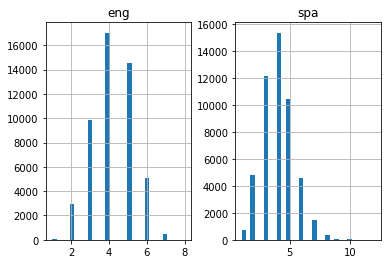

In [18]:
length_df.hist(bins = 30)
plt.show()

Podemos ver que el número máximo de palabras para el inglés son 8 mientras que para el español son 12

In [19]:
# prepare english tokenizer
eng_tokenizer = tokenization(eng_spa[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6942


In [20]:
# prepare Spanish tokenizer
spa_tokenizer = tokenization(eng_spa[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 8
print('Spanish Vocabulary Size: %d' % spa_vocab_size)

Spanish Vocabulary Size: 14196


In [21]:
print(eng_tokenizer.word_counts)

, 1), ('miserable', 1), ('cores', 1), ('landline', 1), ('ram', 1), ('fried', 1), ('bruises', 2), ('press', 3), ('intrude', 1), ('outsider', 1), ('throwing', 1), ('730', 2), ('motherinlaw', 1), ('nuisance', 2), ('skill', 1), ('ace', 3), ('clubs', 1), ('teenage', 1), ('tour', 1), ('consequences', 1), ('npr', 1), ('proposition', 1), ('carols', 1), ('secretary', 3), ('corrections', 1), ('crash', 4), ('cooperation', 1), ('1000', 1), ('partly', 1), ('warmer', 4), ('thai', 3), ('reckon', 1), ('strongly', 1), ('refrain', 2), ('unicycle', 3), ('sawing', 2), ('shredded', 3), ('document', 5), ('cheaply', 1), ('spent', 4), ('stretched', 1), ('thoroughly', 1), ('tend', 2), ('dissuade', 1), ('traffic', 6), ('youtube', 1), ('kobe', 1), ('suggestions', 1), ('stress', 1), ('crossing', 2), ('chores', 2), ('emotionally', 1), ('drained', 1), ('faithful', 1), ('coast', 2), ('difficulties', 1), ('average', 2), ('eighth', 2), ('repairing', 1), ('resigning', 1), ('since', 3), ('checked', 1), ('priorities', 1)

In [22]:
print(spa_tokenizer.word_counts)

al', 2), ('sillas', 6), ('rapidísimo', 1), ('búsqueda', 3), ('direcciones', 1), ('asistió', 2), ('vengó', 2), ('gracia', 4), ('apostó', 3), ('abrochó', 1), ('razonar', 1), ('aseguró', 1), ('agachaba', 1), ('sugeriste', 1), ('investigó', 1), ('destacado', 1), ('necesitó', 1), ('treintas', 1), ('sucesor', 1), ('aparenta', 1), ('ocupa', 2), ('esteroides', 2), ('alistó', 2), ('llenó', 1), ('espacios', 1), ('concedió', 1), ('desvío', 1), ('británico', 1), ('admirador', 2), ('temperamento', 2), ('rendido', 1), ('regañina', 1), ('acceso', 2), ('maritales', 1), ('cantado', 3), ('heredó', 1), ('exesposo', 1), ('yerno', 1), ('compulsivo', 3), ('convicto', 1), ('amistosa', 1), ('imprudente', 2), ('desconocido', 2), ('parpadeando', 1), ('masticando', 2), ('cortando', 1), ('lamentarlo', 1), ('recostado', 1), ('rival', 1), ('porche', 1), ('podando', 1), ('firmando', 1), ('cabro', 1), ('encenagado', 1), ('conversando', 1), ('patadas', 1), ('tacho', 1), ('decoroso', 1), ('necesitado', 2), ('movimiento

### Model Building

In [23]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(eng_spa, test_size=0.2, random_state = 12)

In [24]:
# prepare training data
trainX = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_sequences(spa_tokenizer, spa_length, train[:, 1])

[[   3  182   10 ...    0    0    0]
 [   1 1094    6 ...    0    0    0]
 [  50  101    9 ...    0    0    0]
 ...
 [  44  444  432 ...    0    0    0]
 [  22    4  123 ...  213    0    0]
 [   1  202 2244 ...    0    0    0]]
40000
[[   1   10 1574 ...    0    0    0]
 [4836    4    6 ...    0    0    0]
 [  14 4963    0 ...    0    0    0]
 ...
 [  43  199 1665 ...    0    0    0]
 [  18   12   15 ...    8 1196    0]
 [   2  240 1475 ...    0    0    0]]
40000


In [25]:
test

array([['they are very cheerful', 'ellos son muy optimistas'],
       ['i know tom', 'conozco a tom'],
       ['you may refuse', 'puedes negarte'],
       ...,
       ['get rid of the gun', 'deshágase del arma'],
       ['did you watch this movie', '¿viste esta película'],
       ['i bear him no malice', 'no tengo malicia hacia él']],
      dtype='<U332')

In [26]:
# prepare validation data
testX = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_sequences(spa_tokenizer, spa_length, test[:, 1])

[[  36   16   40 ...    0    0    0]
 [   1   37    3 ...    0    0    0]
 [   2   99 1339 ...    0    0    0]
 ...
 [  56 1781   29 ...    0    0    0]
 [  33    2  217 ...    0    0    0]
 [   1  867   42 ...    0    0    0]]
10000
[[  53   43   28 ...    0    0    0]
 [ 233    4    1 ...    0    0    0]
 [ 108 8599    0 ...    0    0    0]
 ...
 [9604  115  974 ...    0    0    0]
 [1347   55  598 ...    0    0    0]
 [   2   31 6750 ...    0    0    0]]
10000


In [28]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [29]:
model = build_model(eng_vocab_size, spa_vocab_size, eng_length, spa_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [30]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [31]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 254s 8ms/step - loss: 4.2245 - val_loss: 3.6571

Epoch 00001: val_loss improved from inf to 3.65712, saving model to model.h1.24_jan_19
Epoch 2/30
32000/32000 [==============================] - 259s 8ms/step - loss: 3.5678 - val_loss: 3.5723

Epoch 00002: val_loss improved from 3.65712 to 3.57228, saving model to model.h1.24_jan_19
Epoch 3/30
32000/32000 [==============================] - 252s 8ms/step - loss: 3.4279 - val_loss: 3.4912

Epoch 00003: val_loss improved from 3.57228 to 3.49125, saving model to model.h1.24_jan_19
Epoch 4/30
32000/32000 [==============================] - 272s 8ms/step - loss: 3.3058 - val_loss: 3.4221

Epoch 00004: val_loss improved from 3.49125 to 3.42209, saving model to model.h1.24_jan_19
Epoch 5/30
32000/32000 [=============

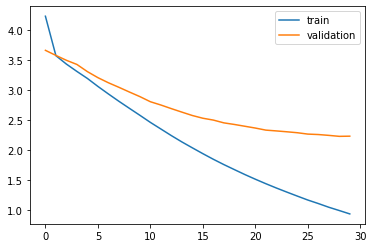

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [33]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [34]:
# convert predictions into text (Spanish)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], spa_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], spa_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [39]:
pred_df = pd.DataFrame({'actual' : test[:,1], 'predicted' : preds_text})

In [40]:
pd.set_option('display.max_colwidth', 200)

In [41]:
pred_df.head(15)

,actual,predicted
0,ellos son muy optimistas,ellos son muy
1,conozco a tom,yo a tom
2,puedes negarte,puedes que
3,eso es privado,eso es caro
4,tom saltó desde su asiento,tom perdió su
5,¿jamás has vendido un auto,¿has vez un vez un coche
6,¿cuántos hijos tienes,¿cuántos años tienes
7,no te dejaré hacerlo,no siquiera lo hacerlo
8,¿no es hermoso,¿no es
9,mi loro murió ayer,mi dolor se bien


***
## SimpleRNN
Probamos a cambiar de modelo, cambiando lstm por un SimpleRNN, pero dejando el resto de parámetros al  mismo valor

In [27]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(SimpleRNN(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(SimpleRNN(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [28]:
model = build_model(eng_vocab_size, spa_vocab_size,eng_length, spa_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.


In [43]:
filename = 'model.h1.5_may_20'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 265s 8ms/step - loss: 0.9359 - val_loss: 2.2330

Epoch 00001: val_loss improved from inf to 2.23296, saving model to model.h1.5_may_20
Epoch 2/30
32000/32000 [==============================] - 259s 8ms/step - loss: 0.8823 - val_loss: 2.2160

Epoch 00002: val_loss improved from 2.23296 to 2.21600, saving model to model.h1.5_may_20
Epoch 3/30
32000/32000 [==============================] - 261s 8ms/step - loss: 0.8327 - val_loss: 2.2344

Epoch 00003: val_loss did not improve from 2.21600
Epoch 4/30
32000/32000 [==============================] - 266s 8ms/step - loss: 0.7853 - val_loss: 2.2057

Epoch 00004: val_loss improved from 2.21600 to 2.20574, saving model to model.h1.5_may_20
Epoch 5/30
32000/32000 [==============================] - 262s 8ms/step - loss: 0.7405 - val_loss: 2.1991

Epoch 00005: val_loss improved from 2.20574 to 2.19911, saving model to model.h1.5_may_20
Epoch 6/3

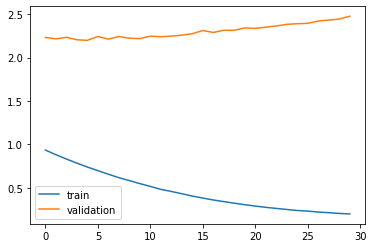

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [45]:
model = load_model('model.h1.5_may_20')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

Como era de esperar, un SimpleRNN no funciona bien en la tarea de Seq2Seq ya que carece de la memoria necesaria

***
## GRU
Ahora probamos con GRU

In [29]:
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(GRU(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(GRU(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [30]:
model = build_model(eng_vocab_size, spa_vocab_size,eng_length, spa_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [31]:
filename = 'model.h1.5_may_20_1920'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 260s 8ms/step - loss: 4.1782 - val_loss: 3.6642

Epoch 00001: val_loss improved from inf to 3.66415, saving model to model.h1.5_may_20_1920
Epoch 2/30
32000/32000 [==============================] - 222s 7ms/step - loss: 3.5440 - val_loss: 3.5506

Epoch 00002: val_loss improved from 3.66415 to 3.55059, saving model to model.h1.5_may_20_1920
Epoch 3/30
32000/32000 [==============================] - 239s 7ms/step - loss: 3.3978 - val_loss: 3.5750

Epoch 00003: val_loss did not improve from 3.55059
Epoch 4/30
32000/32000 [==============================] - 225s 7ms/step - loss: 3.2702 - val_loss: 3.3409

Epoch 00004: val_loss improved from 3.55059 to 3.34093, saving model to model.h1.5_may_20_1920
Epoch 5/30
32000/32000 [==============================] - 225s 7m

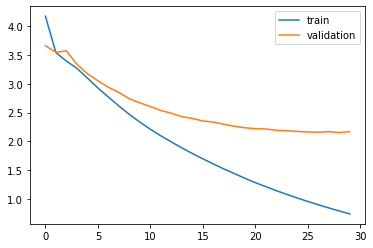

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [33]:
model = load_model('model.h1.5_may_20_1920')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [34]:
# convert predictions into text (Spanish)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], spa_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], spa_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [35]:
pred_df = pd.DataFrame({'actual' : test[:,1], 'predicted' : preds_text})

In [36]:
pd.set_option('display.max_colwidth', 200)

In [37]:
pred_df.head(15)

,actual,predicted
0,ellos son muy optimistas,ellos son muy
1,conozco a tom,yo a tom
2,puedes negarte,puedes que
3,eso es privado,es
4,tom saltó desde su asiento,tom se su asiento
5,¿jamás has vendido un auto,¿has vez has vez un coche
6,¿cuántos hijos tienes,¿cuántos niños tienes
7,no te dejaré hacerlo,no lo
8,¿no es hermoso,¿no es genial
9,mi loro murió ayer,mi ha ayer


***
## LSTM alterando parámetros

In [38]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [39]:
model = build_model(eng_vocab_size, spa_vocab_size,eng_length, spa_length, 128)
rms = optimizers.RMSprop(lr=0.01)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [40]:
filename = 'model.h1.6_may_20_1108'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=128, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 150s 5ms/step - loss: 3.6344 - val_loss: 3.1751

Epoch 00001: val_loss improved from inf to 3.17511, saving model to model.h1.6_may_20_1108
Epoch 2/30
32000/32000 [==============================] - 147s 5ms/step - loss: 2.8270 - val_loss: 2.7362

Epoch 00002: val_loss improved from 3.17511 to 2.73619, saving model to model.h1.6_may_20_1108
Epoch 3/30
32000/32000 [==============================] - 147s 5ms/step - loss: 2.4464 - val_loss: 2.5613

Epoch 00003: val_loss improved from 2.73619 to 2.56134, saving model to model.h1.6_may_20_1108
Epoch 4/30
32000/32000 [==============================] - 147s 5ms/step - loss: 2.2033 - val_loss: 2.4377

Epoch 00004: val_loss improved from 2.56134 to 2.43771, saving model to model.h1.6_may_20_1108
Epoch 5/30
32000/32000 [==============================] - 147s 5ms/step - loss: 2.0176 - val_loss: 2.3741

Epoch 00005: val_loss improved from 2.43

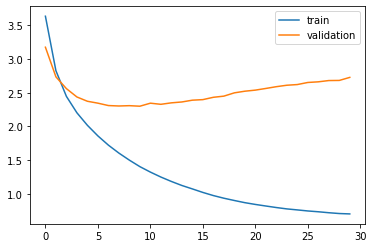

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

En este caso vemos que la curiva de validación en vez de decrecer crece con las épocas, por lo que podríamos pensar que el nuevo lr ha hecho que nuestro modelo sufra de overfitting

### Volvemos a cambiar los varlores de las unidades y el lr, pero manteniendo la misma estructura para la red que antes

In [42]:
model = build_model(eng_vocab_size, spa_vocab_size,eng_length, spa_length, 256)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [43]:
filename = 'model.h1.6_may_20_1245'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=20, batch_size=256, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/20
32000/32000 [==============================] - 174s 5ms/step - loss: 4.1918 - val_loss: 3.7197

Epoch 00001: val_loss improved from inf to 3.71969, saving model to model.h1.6_may_20_1245
Epoch 2/20
32000/32000 [==============================] - 168s 5ms/step - loss: 3.5780 - val_loss: 3.5612

Epoch 00002: val_loss improved from 3.71969 to 3.56125, saving model to model.h1.6_may_20_1245
Epoch 3/20
32000/32000 [==============================] - 170s 5ms/step - loss: 3.4188 - val_loss: 3.4420

Epoch 00003: val_loss improved from 3.56125 to 3.44201, saving model to model.h1.6_may_20_1245
Epoch 4/20
32000/32000 [==============================] - 170s 5ms/step - loss: 3.2760 - val_loss: 3.3259

Epoch 00004: val_loss improved from 3.44201 to 3.32594, saving model to model.h1.6_may_20_1245
Epoch 5/20
32000/32000 [==============================] - 169s 5ms/step - loss: 3.1312 - val_loss: 3.1970

Epoch 00005: val_loss improved from 3.32

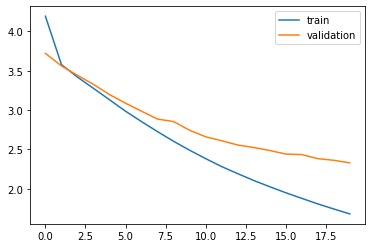

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Cambiamos de optimizador y volvemos al numero inicial de unidades y épocas

In [45]:
model = build_model(eng_vocab_size, spa_vocab_size,eng_length, spa_length, 512)
adam = optimizers.Adam(lr=0.001)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy')

In [46]:
filename = 'model.h1.6_may_20_1505'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 247s 8ms/step - loss: 5.0609 - val_loss: 4.0361

Epoch 00001: val_loss improved from inf to 4.03609, saving model to model.h1.6_may_20_1505
Epoch 2/30
32000/32000 [==============================] - 235s 7ms/step - loss: 3.8377 - val_loss: 3.8142

Epoch 00002: val_loss improved from 4.03609 to 3.81420, saving model to model.h1.6_may_20_1505
Epoch 3/30
32000/32000 [==============================] - 242s 8ms/step - loss: 3.6871 - val_loss: 3.7346

Epoch 00003: val_loss improved from 3.81420 to 3.73460, saving model to model.h1.6_may_20_1505
Epoch 4/30
32000/32000 [==============================] - 242s 8ms/step - loss: 3.6181 - val_loss: 3.7068

Epoch 00004: val_loss improved from 3.73460 to 3.70676, saving model to model.h1.6_may_20_1505
Epoch 5/30
32000/32000 [==============================] - 242s 8ms/step - loss: 3.5776 - val_loss: 3.6827

Epoch 00005: val_loss improved from 3.70

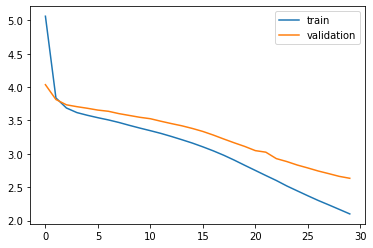

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Vemos que el valor inicial es más alto que en los procesos anteriores